#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [8.983,0], 
    [17.966,0],
    [17.966,13.566],
    [17.966,22.609],
    [27.527,9.560],
    [33.903,15.931],
    [31.441,0],
    
    [40.424, 0],
    [19.560,-01.693],
    [33.904,-15.931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

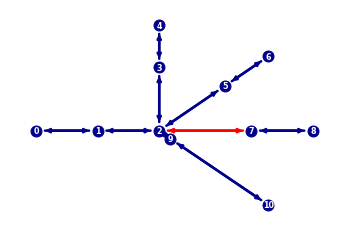

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_depth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

1056 995.4777630730554 1.9098300562505255 Tanker
1056 2357.3339801398893 3.0901699437494736 Tanker
1056 171.52208911192673 1.1803398874989486 Tanker
1056 1044.6032263688046 1.952948260116881 Tanker
1056 1056.6440251292015 1.9635103328589776 Tanker
1056 1056.0063061524618 1.96295099432661 Tanker
1056 1055.9999275090765 1.9629453996310744 Tanker
1056 1055.9960939031682 1.9629420371825557 Tanker
T_Payload2T = 1.96


1.9629453996310744

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [11]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]


In [12]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,2.30,2.5,0.2,150
1,2.25,2.5,0.2,150
2,2.20,2.5,0.2,150
3,2.15,2.5,0.2,150
4,2.10,2.5,0.2,150
5,2.05,2.5,0.2,150
6,2.00,2.5,0.2,150
7,1.95,2.5,0.2,150
8,1.90,2.5,0.2,150
9,1.85,2.5,0.2,150


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [13]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.84,0.00,0.00,2.50,2.50,1441.73
1,2.25,2.50,0.20,150.00,3.19,1.58,0.05,2.45,2.45,1384.33
2,2.20,2.50,0.20,150.00,3.48,2.23,0.10,2.40,2.40,1326.99
3,2.15,2.50,0.20,150.00,3.74,2.73,0.15,2.35,2.35,1269.71
4,2.10,2.50,0.20,150.00,3.98,3.17,0.20,2.30,2.30,1212.50
5,2.05,2.50,0.20,150.00,4.15,3.56,0.25,2.25,2.25,1155.35
6,2.00,2.50,0.20,150.00,4.36,3.92,0.30,2.20,2.20,1098.26
7,1.95,2.50,0.20,150.00,4.50,4.27,0.35,2.15,2.15,1041.24
8,1.90,2.50,0.20,150.00,4.57,4.57,0.40,2.10,2.10,984.28
9,1.85,2.50,0.20,150.00,4.68,4.68,0.41,2.09,2.05,927.39


#### Provide a group of feasible velocities for each T_strategy

In [15]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,NaN,1.58,2.23,2.73,3.17,3.56,3.92,4.27,4.57,4.68,4.72,4.74,4.74,4.73,4.7,4.65,4.59,4.52,4.43
1,NaN,1.48,2.13,2.63,3.07,3.46,3.82,4.17,4.47,4.58,4.62,4.64,4.64,4.63,4.6,4.55,4.49,4.42,4.33
2,NaN,1.38,2.03,2.53,2.97,3.36,3.72,4.07,4.37,4.48,4.52,4.54,4.54,4.53,4.5,4.45,4.39,4.32,4.23
3,NaN,1.28,1.93,2.43,2.87,3.26,3.62,3.97,4.27,4.38,4.42,4.44,4.44,4.43,4.4,4.35,4.29,4.22,4.13
4,NaN,1.18,1.83,2.33,2.77,3.16,3.52,3.87,4.17,4.28,4.32,4.34,4.34,4.33,4.3,4.25,4.19,4.12,4.03
5,NaN,1.08,1.73,2.23,2.67,3.06,3.42,3.77,4.07,4.18,4.22,4.24,4.24,4.23,4.2,4.15,4.09,4.02,3.93
6,NaN,0.98,1.63,2.13,2.57,2.96,3.32,3.67,3.97,4.08,4.12,4.14,4.14,4.13,4.1,4.05,3.99,3.92,3.83
7,NaN,NaN,1.53,2.03,2.47,2.86,3.22,3.57,3.87,3.98,4.02,4.04,4.04,4.03,4.0,3.95,3.89,3.82,3.73
8,NaN,NaN,1.43,1.93,2.37,2.76,3.12,3.47,3.77,3.88,3.92,3.94,3.94,3.93,3.9,3.85,3.79,3.72,3.63
9,NaN,NaN,1.33,1.83,2.27,2.66,3.02,3.37,3.67,3.78,3.82,3.84,3.84,3.83,3.8,3.75,3.69,3.62,3.53


In [16]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [17]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,2.25,1.58,2.5,0.2,150.0
1,2.25,1.48,2.5,0.2,150.0
2,2.25,1.38,2.5,0.2,150.0
3,2.25,1.28,2.5,0.2,150.0
4,2.25,1.18,2.5,0.2,150.0
...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0
568,1.40,1.23,2.5,0.2,150.0
569,1.40,1.13,2.5,0.2,150.0
570,1.40,1.03,2.5,0.2,150.0


In [18]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [19]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,2.3,2.25,2.2,2.15,2.1,2.05,2.0,1.95,1.9,1.85,1.8,1.75,1.7,1.65,1.6,1.55,1.5,1.45,1.4


In [20]:
v_df.T
v_df
max_velocity

4.428522457804811

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [21]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [22]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [23]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    # result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']/3600
    result['transport time (s)'] = 150000/row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]/3600   #  hour--> sec
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]/3600  #  hour--> sec
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]/3600  #  hour--> sec
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]/3600  #  hour--> sec
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())

results_df['transport time (hours)'] = results_df['transport time (s)'] / 3600
results_df['CO2 (ton)'] = results_df['CO2 (g)'] / 1000000
results_df['PM10 (kg)'] = results_df['PM10 (g)'] / 1000
results_df['NOx (kg)'] = results_df['NOx (g)'] / 1000
results_df['Fuel Use (ton)'] = results_df['Fuel Use (g)'] / 1000000
results_df['Fuel cost (MGO_600USD/ton)'] = results_df['Fuel Use (ton)']*600   # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)'] = results_df['CO2 (ton)']*27 # the world bank 2020


results_df
    


Simulating is ongoing:   1%|▌                                                          | 6/572 [00:00<00:11, 49.22it/s]

2.4502699711061102
2.4565933430853466
2.4624715635788745
2.4679071188665453
2.472902667157826
2.4774610654664855
2.4815854034538245
2.4000044628548456
2.4091058196592563


Simulating is ongoing:   3%|█▌                                                        | 16/572 [00:00<00:13, 41.84it/s]

2.417757129238805
2.425960120165291
2.4337166012628932
2.441028469806122
2.4478977210584385
2.45432645947392
2.460316911969211
2.465871443819059


Simulating is ongoing:   5%|██▋                                                       | 26/572 [00:00<00:13, 41.28it/s]

2.470992577921571
2.4756830184687413
2.479945680492685
2.483783727432456
2.3505012403669454
2.361666539758281
2.3723825778781835
2.3826507461212394


Simulating is ongoing:   5%|███▏                                                      | 31/572 [00:00<00:13, 39.53it/s]

2.3924724874566157
2.401849300584605
2.410782744631065
2.4192744444642207
2.4273260967651034
2.4349394769865307


Simulating is ongoing:   7%|████▏                                                     | 41/572 [00:01<00:13, 40.02it/s]

2.4421164473998163
2.448858966457404
2.455169099787876
2.4610490332230452
2.466501088400231
2.4715277416720856
2.4761316473404236
2.480315666657348
2.48408290469899


Simulating is ongoing:   8%|████▋                                                     | 46/572 [00:01<00:13, 40.25it/s]

2.2998548709178945
2.312763902473067
2.3252266646447586
2.337244338344552
2.3488181416616642
2.3599493323930645
2.3706392108429393
2.38088912293812
2.3907004637021005


Simulating is ongoing:  10%|█████▋                                                    | 56/572 [00:01<00:13, 38.75it/s]

2.400074681148219
2.4090132806638733
2.4175178299701696
2.425589964766337
2.433231395189469
2.4404439132564866
2.4472294015030047
2.453589843086956


Simulating is ongoing:  11%|██████▍                                                   | 64/572 [00:01<00:14, 35.22it/s]

2.459527333718108
2.4650440958807684
2.4701424959867104
2.474825065331162
2.4790945260779984
2.4829538240446856


Simulating is ongoing:  12%|██████▉                                                   | 68/572 [00:01<00:15, 31.79it/s]

2.250149194297103
2.2645259551377976
2.2784608651126117
2.2919549598167825
2.30500930360693


Simulating is ongoing:  13%|███████▎                                                  | 72/572 [00:01<00:17, 28.83it/s]

2.3176249913229863
2.329803150165837
2.3415449417624403
2.3528515644354786
2.3637242557076648
2.3741642950813784
2.384173007121229


Simulating is ongoing:  15%|████████▍                                                 | 83/572 [00:02<00:12, 39.34it/s]

2.3937517649029325
2.4029019938745675
2.411625176208356
2.4199228557269934
2.427796643512804
2.4352482243295284
2.4422793640297207
2.4488919181548914
2.455087842007347
2.4608692025501764
2.466238192611219
2.4711971480344714


Simulating is ongoing:  17%|█████████▋                                                | 95/572 [00:02<00:10, 45.79it/s]

2.475748568662629
2.479895144398316
2.4836397881457937
2.2007642713443722
2.2164235102009577
2.231646204316201
2.246433279215979
2.260785683611595
2.274704390644919
2.288190399239617


Simulating is ongoing:  18%|██████████▍                                              | 105/572 [00:02<00:11, 40.78it/s]

2.301244735567594
2.3138684546494663
2.3260626421042354
2.33782841605329
2.349166929230709
2.3600793712892782
2.370566971363296


Simulating is ongoing:  19%|██████████▉                                              | 110/572 [00:02<00:11, 39.65it/s]

2.3806310009035583
2.3902727768396534
2.3994936651112773
2.4082950846385707
2.416678511800739
2.424645485519214
2.432197613056644
2.439336576676259


Simulating is ongoing:  21%|███████████▊                                             | 119/572 [00:03<00:12, 37.74it/s]

2.4460641413420983
2.452382163689936
2.458292602567974
2.463797531541281
2.468899153883216
2.473599820768296
2.477902053659057
2.4818085722970156


Simulating is ongoing:  22%|████████████▋                                            | 127/572 [00:03<00:12, 36.41it/s]

2.4853223303642653
2.1497629015740554
2.1666080105979466
2.1830224258340944
2.199006982885118
2.2145625364634287
2.229689961329731
2.2443901532943022


Simulating is ongoing:  23%|█████████████                                            | 131/572 [00:03<00:13, 33.31it/s]

2.2586640303078345
2.2725125336322303
2.2859366291123697
2.298937308556127
2.3115155912320784
2.3236725255107284


Simulating is ongoing:  24%|█████████████▊                                           | 139/572 [00:03<00:15, 28.80it/s]

2.3354091906512666
2.346726698763803
2.3576261969700636
2.368108869786099
2.378175941758653
2.3878286803990756


Simulating is ongoing:  26%|██████████████▌                                          | 146/572 [00:03<00:14, 30.19it/s]

2.397068399454946
2.405896462576426
2.41431428744505
2.422323350444416
2.4299251919757503
2.4371214225412934
2.443913729752688
2.450303886466529
2.456293760299342


Simulating is ongoing:  27%|███████████████▍                                         | 155/572 [00:04<00:13, 31.87it/s]

2.4618853248620685
2.4670806731541357
2.4718820337170326
2.476291790369375
2.4803125066781653
2.4839469568336416
2.105033515961286


Simulating is ongoing:  28%|███████████████▊                                         | 159/572 [00:04<00:13, 29.94it/s]

2.1227978183649037
2.14013804358627
2.1570549585830343
2.173549346635684
2.18962200809358
2.205273761161807


Simulating is ongoing:  29%|████████████████▋                                        | 168/572 [00:04<00:12, 32.89it/s]

2.220505442757369
2.2353179094281526
2.249712038333355
2.26368872831162
2.277248901027453
2.29039350221651
2.303123503036885
2.315439901535631


Simulating is ongoing:  31%|█████████████████▋                                       | 177/572 [00:04<00:10, 36.11it/s]

2.3273437242558175
2.3388360279860865
2.3499179016820317
2.3605904685819095
2.37085488853974
2.3807123606067804
2.3901641259043593
2.3992114708273773


Simulating is ongoing:  32%|██████████████████▍                                      | 185/572 [00:05<00:10, 36.83it/s]

2.407855730634331
2.4160982934901374
2.423940605039579
2.431384173612198
2.4384305761790235
2.445081465215043
2.451338576665367
2.457203739262101


Simulating is ongoing:  33%|██████████████████▊                                      | 189/572 [00:05<00:11, 33.35it/s]

2.4626788855249266
2.4677660648763036
2.4724674594587186
2.476785403458863
2.4807224070693916
2.484281186720946


Simulating is ongoing:  34%|███████████████████▋                                     | 197/572 [00:05<00:12, 30.03it/s]

2.0938704354971436
2.111712486054836
2.1291387138201436
2.146149852574178
2.1627466513283946
2.178929874996892


Simulating is ongoing:  36%|████████████████████▎                                    | 204/572 [00:05<00:13, 26.63it/s]

2.1947003051189764
2.2100587406311103
2.225005998695274
2.239542915592488
2.253670347676577


Simulating is ongoing:  36%|████████████████████▋                                    | 207/572 [00:05<00:13, 26.87it/s]

2.267389172403272
2.280700289458555
2.293604621952563
2.306103117738618
2.3181967508389416
2.3298865229952064


Simulating is ongoing:  37%|█████████████████████▏                                   | 213/572 [00:06<00:13, 26.05it/s]

2.3411734653694185
2.352058640410804
2.3625431439002256
2.372628107212631
2.3823146998186546


Simulating is ongoing:  38%|█████████████████████▊                                   | 219/572 [00:06<00:14, 24.07it/s]

2.391604132065239
2.4004976582752
2.408996580221173
2.417102251033394
2.424816079620432


Simulating is ongoing:  39%|██████████████████████▍                                  | 225/572 [00:06<00:14, 24.03it/s]

2.4321395356961526
2.4390741555280235
2.4456215485585027
2.4517834050807075
2.457561505212995


Simulating is ongoing:  40%|██████████████████████▋                                  | 228/572 [00:06<00:14, 23.64it/s]

2.4629577294812277
2.467974071424317
2.472612652777899
2.4768757419985
2.4807657771977945


Simulating is ongoing:  41%|███████████████████████▎                                 | 234/572 [00:07<00:14, 23.06it/s]

2.484285395023656
2.0956902474174677
2.1133035640746
2.1305099016753983


Simulating is ongoing:  41%|███████████████████████▌                                 | 237/572 [00:07<00:14, 22.74it/s]

2.1473099721138174
2.163704501923433
2.1796942329270252
2.1952799229186577
2.2104623463981183


Simulating is ongoing:  42%|████████████████████████▏                                | 243/572 [00:07<00:14, 22.82it/s]

2.2252422953633406
2.2396205801487916
2.253598030342594
2.2671754957609336
2.2803538475088123


Simulating is ongoing:  43%|████████████████████████▌                                | 246/572 [00:07<00:15, 21.47it/s]

2.293133979123334
2.3055168078144015
2.3175032758112017
2.329094351831756
2.3402910326894664


Simulating is ongoing:  44%|█████████████████████████                                | 252/572 [00:08<00:16, 19.13it/s]

2.3510943450413695
2.361505347325811
2.3715251318798254
2.3811548272923027
2.3903956010070626


Simulating is ongoing:  45%|█████████████████████████▉                               | 260/572 [00:08<00:11, 26.12it/s]

2.399248662226471
2.4077152651538842
2.4157967126392093
2.4234943602911607
2.430809621144613
2.4377439709852218
2.444298954464041


Simulating is ongoing:  46%|██████████████████████████▏                              | 263/572 [00:08<00:12, 25.19it/s]

2.4504761921678577
2.456277388856281
2.4617043431401857
2.466758958963266
2.471443259367134


Simulating is ongoing:  47%|██████████████████████████▊                              | 269/572 [00:08<00:12, 23.72it/s]

2.475759403195976
2.4797097056521316
2.48329666399734
2.4865229902971557
2.101320503466886


Simulating is ongoing:  48%|███████████████████████████                              | 272/572 [00:08<00:13, 22.73it/s]

2.1186161048075123
2.135513771055412
2.1520141952499348
2.1681180846261765


Simulating is ongoing:  49%|███████████████████████████▋                             | 278/572 [00:09<00:13, 21.89it/s]

2.1838261612280245
2.1991391625777323
2.214057842376212
2.228582971266849
2.2427153376507527


Simulating is ongoing:  50%|████████████████████████████▎                            | 284/572 [00:09<00:13, 21.08it/s]

2.2564557485630186
2.2698050306129
2.2827640310054598
2.2953336186392947


Simulating is ongoing:  50%|████████████████████████████▌                            | 287/572 [00:09<00:13, 21.67it/s]

2.3075146853030377
2.319308146967685
2.330714945197525
2.34173604869207
2.3523724549699234


Simulating is ongoing:  51%|█████████████████████████████▏                           | 293/572 [00:09<00:11, 23.84it/s]

2.362625192216429
2.3724953213238575
2.381983938137278
2.3910921759513304
2.399821208281899
2.4081722519695345


Simulating is ongoing:  53%|█████████████████████████████▉                           | 301/572 [00:09<00:09, 29.44it/s]

2.4161465706553975
2.4237454787063903
2.4309703456587277
2.437822601285811
2.444303741408711
2.4504153346050574
2.456159030012987
2.461536566484175


Simulating is ongoing:  54%|██████████████████████████████▊                          | 309/572 [00:10<00:08, 32.30it/s]

2.466549783421173
2.4712006337400747
2.475491199562205
2.4794237114660262
2.4830005724773296
2.486224388511151


Simulating is ongoing:  55%|███████████████████████████████▏                         | 313/572 [00:10<00:08, 31.13it/s]

2.1105724180320813
2.12746665078629
2.1439721830874072
2.160089691891837
2.175819868022296
2.1911634167666354


Simulating is ongoing:  56%|███████████████████████████████▉                         | 321/572 [00:10<00:08, 31.22it/s]

2.206121058531874
2.2206935295282424
2.23488158251527
2.2486859875981158
2.2621075330835003
2.275147026398054


Simulating is ongoing:  57%|████████████████████████████████▍                        | 326/572 [00:10<00:07, 33.84it/s]

2.2878052950862626
2.3000831878827173
2.311981575880851
2.3235013537952725
2.334643441339957
2.34540878473439
2.355798358348364
2.365813166506745
2.375454245482317


Simulating is ongoing:  59%|█████████████████████████████████▍                       | 335/572 [00:10<00:06, 37.82it/s]

2.3847226656895337
2.3936195341233497
2.4021459970665746
2.410303243121274
2.418092506604051
2.425515071380088
2.432572275203598
2.439265514668095
2.4455962508820313
2.451566016022003


Simulating is ongoing:  60%|██████████████████████████████████▍                      | 345/572 [00:11<00:05, 41.35it/s]

2.457176420955592
2.462429164181992
2.46732604241785
2.4718689632591135
2.4760599605085734
2.479901212981004
2.4833950679366263
2.486544070816578
2.121542341067051
2.1379949848932753


Simulating is ongoing:  62%|███████████████████████████████████▍                     | 355/572 [00:11<00:05, 39.14it/s]

2.1540682801456734
2.1697628889407246
2.1850794869793333
2.200018764150156
2.214581425154041
2.228768190198769
2.2425797957149434
2.256016995149093


Simulating is ongoing:  64%|████████████████████████████████████▎                    | 365/572 [00:11<00:04, 41.46it/s]

2.2690805597995167
2.2817712797187286
2.2940899647030744
2.3060374453389136
2.3176145741558467
2.3288222268715613
2.339661303746555
2.35013273106777
2.3602374627669724
2.36997648220388


Simulating is ongoing:  66%|█████████████████████████████████████▎                   | 375/572 [00:11<00:04, 43.05it/s]

2.3793508041256515
2.3883614768333543
2.3970095845855424
2.405296250272053
2.413222638404688
2.420789958471642
2.4279994687260373
2.4348524804767115
2.441350362987213


Simulating is ongoing:  67%|██████████████████████████████████████▎                  | 385/572 [00:12<00:04, 42.86it/s]

2.4474945490918705
2.4532865416896836
2.458727921300204
2.4638203549367774
2.468565606619729
2.4729655499677845
2.477022183458771
2.48073764917989


Simulating is ongoing:  68%|██████████████████████████████████████▊                  | 390/572 [00:12<00:04, 42.70it/s]

2.4841142562323406
2.4871545104893453
2.1357120032796675
2.1516485626177575
2.1672153041870192
2.1824128777182685
2.197241946369193
2.2117031873089106
2.2257972923602702


Simulating is ongoing:  70%|███████████████████████████████████████▊                 | 400/572 [00:12<00:04, 42.86it/s]

2.2395249686688983
2.2528869394355007
2.2658839446927606
2.278516742144866
2.290786108067479
2.3026928382950365
2.314237749266348
2.3254216791775923
2.336245489225348


Simulating is ongoing:  72%|████████████████████████████████████████▊                | 410/572 [00:12<00:03, 43.51it/s]

2.3467100649676063
2.3568163178043684
2.366565186607034
2.375957639501629
2.384994675842447
2.3936773283888813
2.402006665725356
2.4099837949574394
2.4176098647294317


Simulating is ongoing:  73%|█████████████████████████████████████████▊               | 420/572 [00:12<00:03, 43.17it/s]

2.424886068616177
2.431813648956546
2.4383939012070304
2.4446281789139843
2.4505178994341277
2.4560645505551175
2.461269698223958
2.4661349956431944


Simulating is ongoing:  74%|██████████████████████████████████████████▎              | 425/572 [00:13<00:03, 42.35it/s]

2.470662194083099
2.4748531558754565
2.4787098702225667
2.482234472709678
2.4854292697879745
2.1527718323267866
2.168123492160027
2.1831150383939364
2.1977471107384465


Simulating is ongoing:  76%|███████████████████████████████████████████▎             | 435/572 [00:13<00:03, 42.60it/s]

2.212020362264972
2.225935460014223
2.2394930856249515
2.252693936023453
2.265538724150502
2.2780281797546467
2.2901630502417634
2.3019441015862108
2.313372119321809


Simulating is ongoing:  78%|████████████████████████████████████████████▎            | 445/572 [00:13<00:02, 42.89it/s]

2.3244479096179425
2.3351723004397478
2.345546142816857
2.3555703122291924
2.3652457101165263
2.3745732655419425
2.3835539370170595
2.39218871452361
2.4004786217474767


Simulating is ongoing:  80%|█████████████████████████████████████████████▎           | 455/572 [00:13<00:02, 42.83it/s]

2.4084247185683134
2.416028103836121
2.423289918489678
2.4302113490666075
2.43679363168389
2.443038056567275
2.4489459732460666
2.4545187965449258


Simulating is ongoing:  80%|█████████████████████████████████████████████▊           | 460/572 [00:13<00:02, 43.36it/s]

2.459758013548226
2.464665191762028
2.469241988767735
2.473490163756663
2.4774115914755375
2.4810082793115487
2.4842823885465486
2.4872362612754175
2.170884423837733


Simulating is ongoing:  82%|██████████████████████████████████████████████▊          | 470/572 [00:14<00:02, 42.68it/s]

2.1856232353680394
2.200011744165018
2.2140505809113846
2.2277403896492927
2.2410818283913354
2.2540755697564987
2.266722301672495
2.2790227281219044
2.290977569936592


Simulating is ongoing:  84%|███████████████████████████████████████████████▊         | 480/572 [00:14<00:02, 43.26it/s]

2.3025875656722152
2.3138534725325206
2.324776067389671
2.3353561478758222
2.3455945335749266
2.355492067328624
2.3650496166513952
2.374268075291906
2.3831483649436933


Simulating is ongoing:  86%|████████████████████████████████████████████████▊        | 490/572 [00:14<00:01, 44.00it/s]

2.3916914371341367
2.399898275313174
2.4077698971748394
2.4153073572443935
2.4225117497746855
2.4293842120046416
2.4359259278431824
2.442138132054918
2.4480221150445685


Simulating is ongoing:  87%|█████████████████████████████████████████████████▎       | 495/572 [00:14<00:01, 43.97it/s]

2.453579228364182
2.458810891091944
2.4637185972846996
2.4683039247571923
2.4725685455284854
2.476514238390933
2.480142904222604
2.4834565849162056
2.4864574871724243


Simulating is ongoing:  88%|██████████████████████████████████████████████████▎      | 505/572 [00:14<00:01, 43.42it/s]

2.1898725863934447
2.203973539076885
2.2177341057340323
2.231154909005605
2.2442365849376413
2.2569797835979424
2.2693851697411844
2.2814534235126107
2.293185241217804


Simulating is ongoing:  90%|███████████████████████████████████████████████████▎     | 515/572 [00:15<00:01, 43.24it/s]

2.3045813361405507
2.3156424394331663
2.3263693010761024
2.3367626909193135
2.34682339981241
2.3565522408381128
2.3659500506606896
2.3750176909933303
2.383756050224514


Simulating is ongoing:  92%|████████████████████████████████████████████████████▎    | 525/572 [00:15<00:01, 43.93it/s]

2.3921660451952085
2.4002486231739746
2.408004764041826
2.41543548272935
2.4225418319382146
2.429324905201031
2.43578584033293
2.4419258233490524
2.4477460929337105
2.453247945572625


Simulating is ongoing:  94%|█████████████████████████████████████████████████████▎   | 535/572 [00:15<00:00, 44.50it/s]

2.4584327414873304
2.463301911548887
2.4678569654013716
2.472099501098795
2.4760312166586838
2.4796539240829483
2.4829695666109783
2.4859802402917026
2.488688221467245
2.2109136468622417


Simulating is ongoing:  95%|██████████████████████████████████████████████████████▎  | 545/572 [00:15<00:00, 43.57it/s]

2.224321647723367
2.2373993455689374
2.2501473572872177
2.2625663133410887
2.2746568583947355
2.2864196520079156
2.2978553693676536
2.308964702078232
2.3197483590274905


Simulating is ongoing:  97%|███████████████████████████████████████████████████████▎ | 555/572 [00:16<00:00, 44.04it/s]

2.330207067302645
2.3403415731998103
2.350152643313729
2.3596410657236784
2.368807651292233
2.377653235081977
2.3861786779164382
2.3943848680954027


Simulating is ongoing:  98%|███████████████████████████████████████████████████████▊ | 560/572 [00:16<00:00, 43.64it/s]

2.402272723291423
2.409843192653886
2.4170972591496267
2.4240359421809425
2.430660300522029
2.4369714356354244
2.4429704954281233
2.4486586785401094
2.4540372392606105
2.459107493212784


Simulating is ongoing: 100%|█████████████████████████████████████████████████████████| 572/572 [00:16<00:00, 34.82it/s]

2.463870823968064
2.46832869081371
2.4724826379559466
2.476334305542373
2.47988544302103
2.483137925554205
2.4860937745066174
2.488755183495298


,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),CO2 (ton),PM10 (kg),NOx (kg),Fuel Use (ton),Fuel cost (MGO_600USD/ton),Carbon cost (EU_27USD/ton)
0,2.25,1.58,2.5,0.2,150.0,94936.708861,3117.135643,9889.821268,8.283210,168.131306,0.200270,1384.325488,26.371308,0.009890,0.008283,0.168131,0.003117,1.870281,0.267025
1,2.25,1.48,2.5,0.2,150.0,101351.351351,3072.823650,9749.231400,8.670623,173.260040,0.206593,1384.325488,28.153153,0.009749,0.008671,0.173260,0.003073,1.843694,0.263229
2,2.25,1.38,2.5,0.2,150.0,108695.652174,3096.842673,9825.437210,9.102057,180.027031,0.212472,1384.325488,30.193237,0.009825,0.009102,0.180027,0.003097,1.858106,0.265287
3,2.25,1.28,2.5,0.2,150.0,117187.500000,3145.793630,9980.745245,9.574362,187.761032,0.217907,1384.325488,32.552083,0.009981,0.009574,0.187761,0.003146,1.887476,0.269480
4,2.25,1.18,2.5,0.2,150.0,127118.644068,3190.702329,10123.228298,10.059256,195.624238,0.222903,1384.325488,35.310734,0.010123,0.010059,0.195624,0.003191,1.914421,0.273327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0,112781.954887,2689.421394,8532.800605,8.687548,167.996164,1.076334,418.202940,31.328321,0.008533,0.008688,0.167996,0.002689,1.613653,0.230386
568,1.40,1.23,2.5,0.2,150.0,121951.219512,2779.154066,8817.497899,9.157621,176.283652,1.079885,418.202940,33.875339,0.008817,0.009158,0.176284,0.002779,1.667492,0.238072
569,1.40,1.13,2.5,0.2,150.0,132743.362832,2904.611101,9215.538857,9.731554,186.630912,1.083138,418.202940,36.873156,0.009216,0.009732,0.186631,0.002905,1.742767,0.248820
570,1.40,1.03,2.5,0.2,150.0,145631.067961,3074.467846,9754.447983,10.443911,199.677234,1.086094,418.202940,40.453074,0.009754,0.010444,0.199677,0.003074,1.844681,0.263370


#### Advanced Parallel Coordinates Plot

In [24]:
strategies_df = results_df

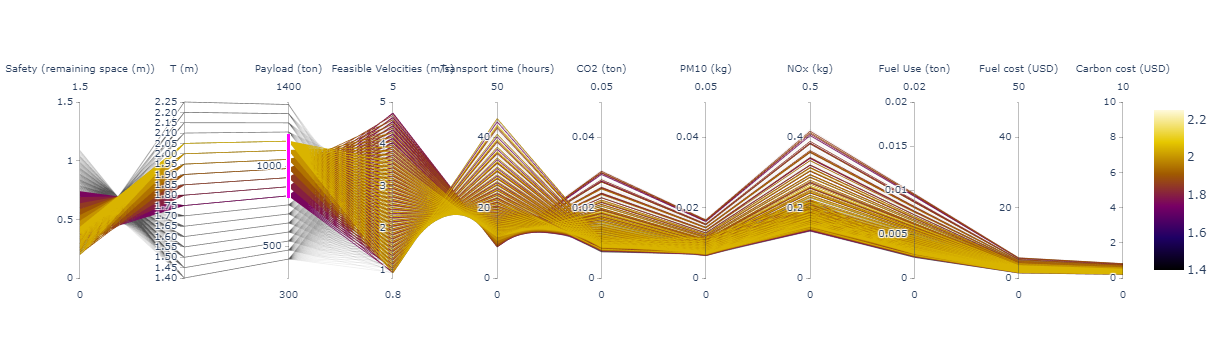

In [30]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T_strategy']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,5],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,50],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,0.05],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,0.05],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,0.5],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [0,0.02],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,50],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,10],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [26]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [27]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>